In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import optuna

In [31]:
def PCA_analysis_all_data(directories, data_set_label, scaler, n_components):
    
    df_list = []
    all_labels = []

    for i, directory in enumerate(directories):

        label = data_set_label[i]
            
        full_paths = glob.glob(os.path.join(directory, 'spins_iter-*.csv'))

        flist = []
        for filename in full_paths:
            df = pd.read_csv(filename, header=None) 
            flist.append(df)
            all_labels.append(label)

        arraylist = []
        for file in flist:
            array = file.to_numpy()
            flattened_array = array.flatten()
            arraylist.append(flattened_array)
        
        df = pd.DataFrame(arraylist)
        df_list.append(df)

    merged_df = pd.concat(df_list, ignore_index=True) 
    labels = pd.Series(all_labels, name='dataset')
 
    scaled = scaler.fit_transform(merged_df)

    pca = sklearn.decomposition.PCA(n_components)
    pca.fit(scaled)

    principal_components = pca.transform(scaled)

    return principal_components, labels

def clusters(pca, model=sklearn.cluster.KMeans(n_clusters=2, random_state=42)):
    
    cluster_labels = model.fit_predict(pca)

    return cluster_labels

def PCA_plots(principal_components, n_components, fig_name, labels):

    pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    pc_df['dataset'] = labels
    sns.pairplot(pc_df, hue='dataset')
    plt.savefig(fig_name)
    plt.show()
    
    return

def tSNE_analysis_all_data(directories, data_set_label, scaler, n_components, perplexity=30, n_iter=250):
    
    df_list = []
    all_labels = []

    for i, directory in enumerate(directories):

        label = data_set_label[i]
            
        full_paths = glob.glob(os.path.join(directory, 'spins_iter-*.csv'))

        flist = []
        for filename in full_paths:
            df = pd.read_csv(filename, header=None) 
            flist.append(df)
            all_labels.append(label)

        arraylist = []
        for file in flist:
            array = file.to_numpy()
            flattened_array = array.flatten()
            arraylist.append(flattened_array)
        
        df = pd.DataFrame(arraylist)
        df_list.append(df)

    merged_df = pd.concat(df_list, ignore_index=True) 
    labels = pd.Series(all_labels, name='dataset')
 
    scaled = scaler.fit_transform(merged_df)

    tsne = sklearn.manifold.TSNE(n_components, random_state=42, perplexity=perplexity, n_iter=n_iter)
    tsne_x = tsne.fit_transform(scaled)

    return tsne_x, labels

def tsne_plots(tsne, n_components, fig_name, labels):

    pc_df = pd.DataFrame(data=tsne, columns=[f'tSNE{i+1}' for i in range(n_components)])
    pc_df['dataset'] = labels
    sns.pairplot(pc_df, hue='dataset')
    plt.savefig(fig_name)
    plt.show()
    
    return

In [ ]:
n_trials = 50

## Changing betaJ

## PCA

[I 2025-07-14 14:25:05,849] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


[I 2025-07-14 14:26:19,748] Trial 0 finished with value: 0.599849413903523 and parameters: {'n_components': 3, 'scaler_type': 'PowerTransformer'}. Best is trial 0 with value: 0.599849413903523.


Optimization finished.


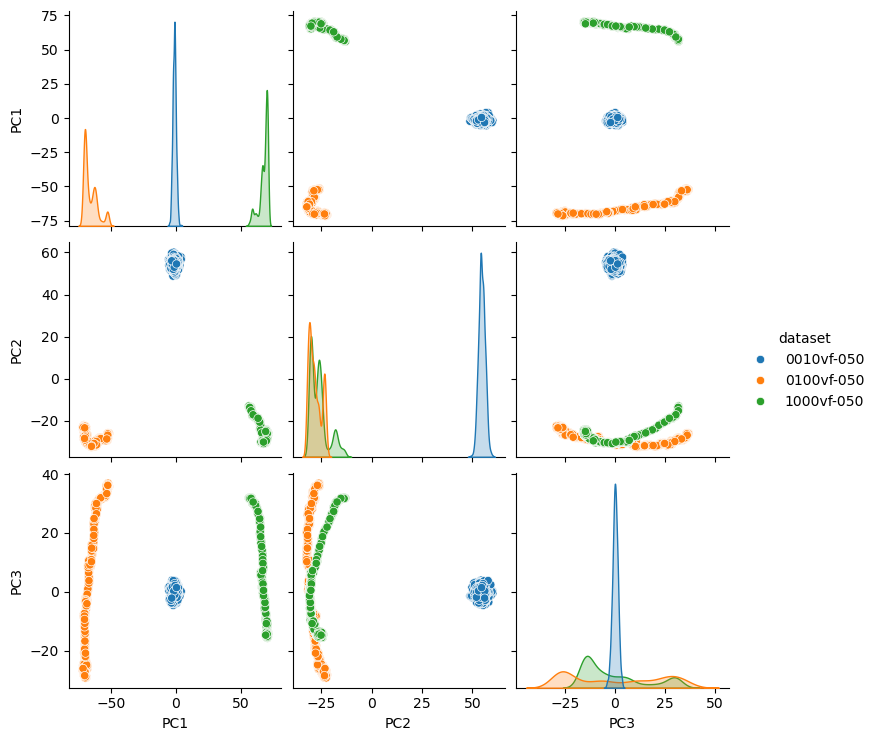

In [ ]:
directory_list = ['/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100']

dataset_label = ['0010vf-050', '0100vf-050', '1000vf-050']

def objective(trial):

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca, x = PCA_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=_n_trials)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

principal_components, labels = PCA_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=best_n_components, scaler=scaler_type)
PCA_plots(principal_components=principal_components, n_components=best_n_components, fig_name='betaJ_PCA.png', labels=labels)

## TSNE

[I 2025-07-14 14:59:27,422] A new study created in memory with name: pca_optimization


Starting PCA and KMeans hyperparameter optimization


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
[I 2025-07-14 15:00:44,010] Trial 0 finished with value: 0.22857666015625 and parameters: {'n_components': 3, 'scaler_type': 'RobustScaler', 'perplexity_sug': 6.0205703562967, 'n_iter_sug': 1000}. Best is trial 0 with value: 0.22857666015625.


Optimization finished.


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


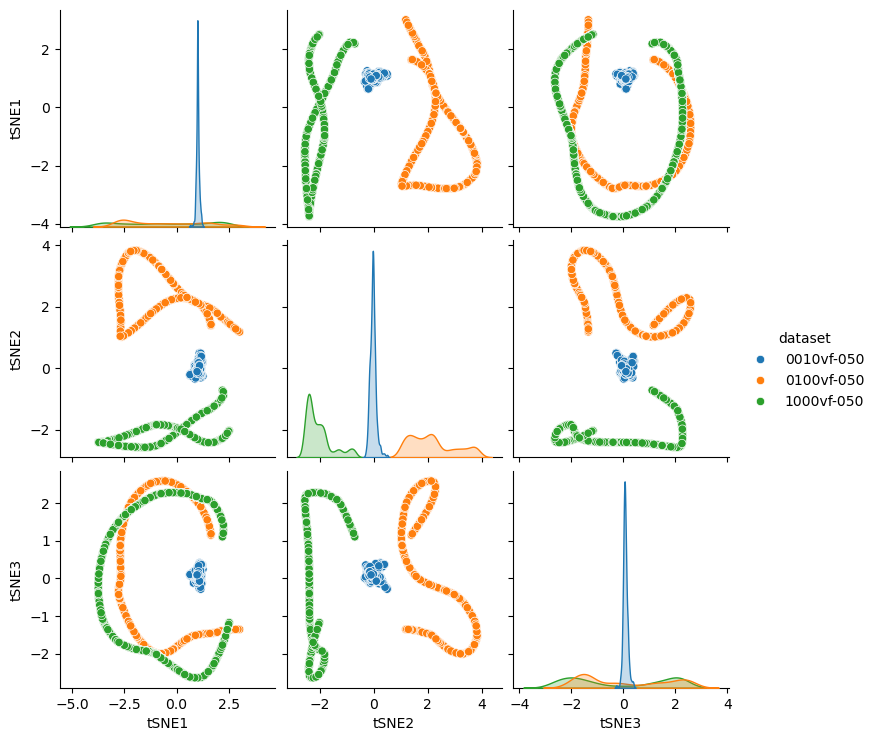

In [ ]:
directory_list = ['/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100']

dataset_label = ['0010vf-050', '0100vf-050', '1000vf-050']

def objective(trial):

    n_components = trial.suggest_int('n_components', 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])
    perplexity = trial.suggest_float('perplexity', 5, 50, step=0.5)
    n_iter = trial.suggest_int('n_iter', 250, 2000, step=50)

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    tsne, x = tSNE_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=n_components, scaler=scaler_type, perplexity=perplexity, n_iter=n_iter)
    cluster_labels = clusters(pca=tsne)

    score = sklearn.metrics.silhouette_score(tsne, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='tsne_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting TSNE hyperparameter optimization")
    study.optimize(objective, n_trials=n_trials)
    print("Optimization finished.")
    print("\nTSNE Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']
best_perplexity = study.best_params['perplexity']
best_iter = study.best_params['n_iters']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

tsne, labels = tSNE_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=best_n_components, scaler=scaler_type, perplexity=best_perplexity, n_iters=best_iter)
tsne_plots(tsne=tsne, n_components=best_n_components, fig_name='betaJ_tsne.png', labels=labels)

## Changing Volume Fraction

## PCA

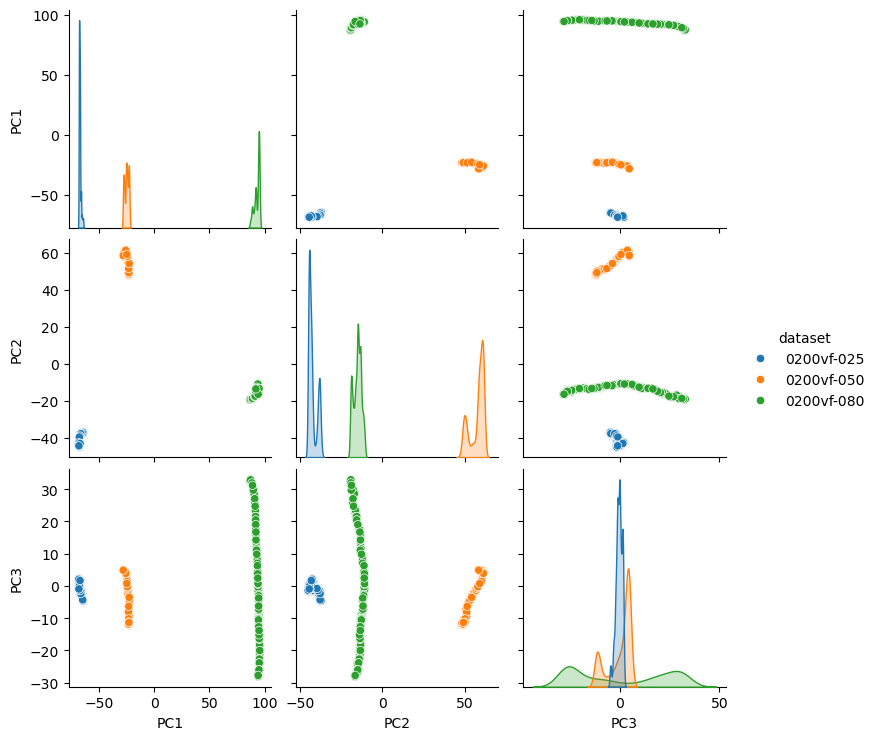

In [ ]:
directory_list = ['/home/user/IsingData/Data/betaJ-0200_vf-025_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0200_vf-080_nrows-100_ncols-100']

dataset_label = ['0200vf-025', '0200vf-050', '0200vf-080']

def objective(trial):

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca, x = PCA_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=n_trials)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

principal_components, labels = PCA_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=best_n_components, scaler=scaler_type)
PCA_plots(principal_components=principal_components, n_components=best_n_components, fig_name='volume_PCA.png', labels=labels)

## TSNE

In [ ]:
directory_list = ['/home/user/IsingData/Data/betaJ-0200_vf-025_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0200_vf-080_nrows-100_ncols-100']

dataset_label = ['0200vf-025', '0200vf-050', '0200vf-080']

def objective(trial):

    n_components = trial.suggest_int('n_components', 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])
    perplexity = trial.suggest_float('perplexity', 5, 50, step=0.5)
    n_iter = trial.suggest_int('n_iter', 250, 2000, step=50)

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    tsne, x = tSNE_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=n_components, scaler=scaler_type, perplexity=perplexity, n_iter=n_iter)
    cluster_labels = clusters(pca=tsne)

    score = sklearn.metrics.silhouette_score(tsne, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='tsne_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting TSNE hyperparameter optimization")
    study.optimize(objective, n_trials=n_trials)
    print("Optimization finished.")
    print("\nTSNE Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']
best_perplexity = study.best_params['perplexity']
best_iter = study.best_params['n_iters']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

tsne, labels = tSNE_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=best_n_components, scaler=scaler_type, perplexity=best_perplexity, n_iters=best_iter)
tsne_plots(tsne=tsne, n_components=best_n_components, fig_name='volume_tsne.png', labels=labels)